"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
import ast

In [2]:
RND_SEED = 30

### load biopsy_df.csv that was generated earlier in "generate_multi_strat_common_test.ipynb" and it is already filtered, cleaned

In [3]:
biopsy_df = pd.read_csv("../biopsy_df.csv")
biopsy_df["base_slide_number"] = biopsy_df["base_slide_number"].astype(str)

In [4]:
biopsy_df.shape

(286, 17)

In [5]:
Counter(biopsy_df.clinical_stage.values)

Counter({np.int64(2): 145, np.int64(1): 84, np.int64(3): 57})

In [6]:
biopsy_df["Patients age"].isna().any()

np.False_

### generate column for stratification: stage, age

In [7]:
biopsy_df["Patients age"].min(), biopsy_df["Patients age"].max()

(np.int64(28), np.int64(92))

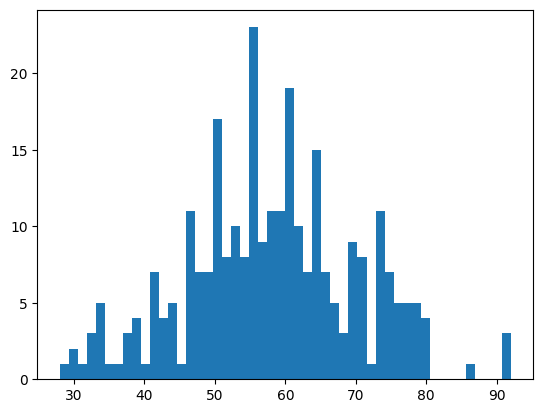

In [8]:
plt.hist(biopsy_df["Patients age"], bins=50);

In [9]:
quantiles = biopsy_df["Patients age"].quantile([0, 1/3, 2/3, 1]).tolist()
quantiles

[28.0, 53.0, 62.99999999999997, 92.0]

In [10]:
biopsy_df['age_categories'] = pd.cut(biopsy_df["Patients age"], bins=quantiles, labels=[0, 1, 2], include_lowest=True)

In [11]:
biopsy_df['stratify_col'] = biopsy_df["clinical_stage"].astype(str) + "_" + \
                            biopsy_df['age_categories'].astype(str)

cv_split_dir_name = "cv_splits_sote_multi_stratified_sklearn_s_a_paper_patients_rev"
os.makedirs(cv_split_dir_name, exist_ok=True)

In [12]:
biopsy_df['stratify_col']

0      3_0
1      2_0
2      2_2
3      2_0
4      1_0
      ... 
281    1_2
282    1_2
283    2_2
284    2_0
285    2_0
Name: stratify_col, Length: 286, dtype: object

### Generate local test set (20%)

In [13]:
n_splits = int(1 // (0.2))

X = biopsy_df[['base_slide_number', 'Slide number']]
y = biopsy_df['stratify_col']

cv = StratifiedGroupKFold(n_splits=n_splits)

In [14]:
train_splits = []
val_splits = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=biopsy_df['base_slide_number'])):
    train_set = biopsy_df.iloc[train_idx]
    val_set = biopsy_df.iloc[val_idx]
    
    print(f"Fold {fold + 1}")
    print("Train Set:      ", train_set.shape, np.unique(train_set.clinical_stage.values, return_counts=True))
    print("Validation Set: ", val_set.shape, np.unique(val_set.clinical_stage.values, return_counts=True))
    print("-" * 40)
    
    train_splits.append(train_idx)
    val_splits.append(val_idx)

Fold 1
Train Set:       (214, 19) (array([1, 2, 3]), array([ 63, 108,  43]))
Validation Set:  (72, 19) (array([1, 2, 3]), array([21, 37, 14]))
----------------------------------------
Fold 2
Train Set:       (214, 19) (array([1, 2, 3]), array([ 63, 109,  42]))
Validation Set:  (72, 19) (array([1, 2, 3]), array([21, 36, 15]))
----------------------------------------
Fold 3
Train Set:       (215, 19) (array([1, 2, 3]), array([ 63, 109,  43]))
Validation Set:  (71, 19) (array([1, 2, 3]), array([21, 36, 14]))
----------------------------------------
Fold 4
Train Set:       (215, 19) (array([1, 2, 3]), array([ 63, 109,  43]))
Validation Set:  (71, 19) (array([1, 2, 3]), array([21, 36, 14]))
----------------------------------------


In [15]:
len(train_splits), len(val_splits)

(4, 4)

In [16]:
biopsy_df_test = biopsy_df.iloc[val_splits[0]]

In [17]:
biopsy_df_test.shape, Counter(biopsy_df_test.clinical_stage.values)

((72, 19), Counter({np.int64(2): 37, np.int64(1): 21, np.int64(3): 14}))

In [18]:
biopsy_df_test.to_csv(f"{cv_split_dir_name}/test_split_multi_stratified.csv", index=False)

In [19]:
biopsy_df_rest = biopsy_df.iloc[ ~np.in1d(biopsy_df.index.values, val_splits[0]) ].reset_index(drop=True)

/tmp/ipykernel_2243839/3603915552.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  biopsy_df_rest = biopsy_df.iloc[ ~np.in1d(biopsy_df.index.values, val_splits[0]) ].reset_index(drop=True)


In [20]:
biopsy_df_rest.shape

(214, 19)

In [21]:
Counter(biopsy_df_rest.clinical_stage.values)

Counter({np.int64(2): 108, np.int64(1): 63, np.int64(3): 43})

### Generate train-val folds

In [22]:
n_splits = 5

X = biopsy_df_rest[['base_slide_number', 'Slide number']]
y = biopsy_df_rest['stratify_col']

cv = StratifiedGroupKFold(n_splits=n_splits)

In [23]:
train_splits = []
val_splits = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=biopsy_df_rest['base_slide_number'])):
    train_set = biopsy_df_rest.iloc[train_idx]
    val_set = biopsy_df_rest.iloc[val_idx]
    
    print(f"Fold {fold + 1}")
    print("Train Set:      ", train_set.shape, np.unique(train_set.clinical_stage.values, return_counts=True))
    print("Validation Set: ", val_set.shape, np.unique(val_set.clinical_stage.values, return_counts=True))
    print("-" * 40)
    
    train_splits.append(train_idx)
    val_splits.append(val_idx)

Fold 1
Train Set:       (171, 19) (array([1, 2, 3]), array([50, 86, 35]))
Validation Set:  (43, 19) (array([1, 2, 3]), array([13, 22,  8]))
----------------------------------------
Fold 2
Train Set:       (171, 19) (array([1, 2, 3]), array([52, 85, 34]))
Validation Set:  (43, 19) (array([1, 2, 3]), array([11, 23,  9]))
----------------------------------------
Fold 3
Train Set:       (171, 19) (array([1, 2, 3]), array([50, 87, 34]))
Validation Set:  (43, 19) (array([1, 2, 3]), array([13, 21,  9]))
----------------------------------------
Fold 4
Train Set:       (171, 19) (array([1, 2, 3]), array([50, 87, 34]))
Validation Set:  (43, 19) (array([1, 2, 3]), array([13, 21,  9]))
----------------------------------------
Fold 5
Train Set:       (172, 19) (array([1, 2, 3]), array([50, 87, 35]))
Validation Set:  (42, 19) (array([1, 2, 3]), array([13, 21,  8]))
----------------------------------------


In [24]:
# check if there is any overlap in the val sets
for i in range(n_splits-1):
    print(list(set(val_splits[0]) & set(val_splits[i+1])))

[]
[]
[]
[]


In [25]:
for s in range(n_splits):
    # save train set
    biopsy_df_rest.iloc[train_splits[s]].to_csv(f"{cv_split_dir_name}/train_split_multi_stratified_{s}.csv", index=False)
    
    # save val set
    biopsy_df_rest.iloc[val_splits[s]].to_csv(f"{cv_split_dir_name}/val_split_multi_stratified_{s}.csv", index=False)

In [26]:
biopsy_df.to_csv(f"{cv_split_dir_name}/biopsy_df.csv", index=False)